In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [2]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        self.pe = pe.unsqueeze(0)
    
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

In [3]:
class SelfAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(SelfAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        assert (
            self.head_dim * heads == embed_size
        ), "Embed size must be divisible by heads"

        self.values = nn.Linear(embed_size, embed_size)
        self.keys = nn.Linear(embed_size, embed_size)
        self.queries = nn.Linear(embed_size, embed_size)
        self.fc_out = nn.Linear(embed_size, embed_size)

    def forward(self, values, keys, query, mask):
        N = query.shape[0]
        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

        values = self.values(values)
        keys = self.keys(keys)
        queries = self.queries(query)

        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, float("-1e20"))

        attention = torch.nn.functional.softmax(energy / (self.embed_size ** (1 / 2)), dim=3)
        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(N, query_len, self.embed_size)
        return self.fc_out(out)


In [4]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, dropout, forward_expansion):
        super(TransformerBlock, self).__init__()
        self.attention = SelfAttention(embed_size, heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)
        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, forward_expansion * embed_size),
            nn.ReLU(),
            nn.Linear(forward_expansion * embed_size, embed_size)
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, value, key, query, mask):
        attention = self.attention(value, key, query, mask)
        x = self.dropout(self.norm1(attention + query))
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x))
        return out


In [5]:
class Transformer(nn.Module):
    def __init__(self, embed_size, heads, num_layers, forward_expansion, dropout, vocab_size, max_length):
        super(Transformer, self).__init__()
        self.embed_size = embed_size
        self.word_embedding = nn.Embedding(vocab_size, embed_size)
        self.position_embedding = PositionalEncoding(embed_size, max_length)
        self.layers = nn.ModuleList([
            TransformerBlock(embed_size, heads, dropout, forward_expansion) for _ in range(num_layers)
        ])
        self.fc_out = nn.Linear(embed_size, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        x = self.word_embedding(x)
        x = self.position_embedding(x)
        
        for layer in self.layers:
            x = layer(x, x, x, mask)
        
        return self.fc_out(x)


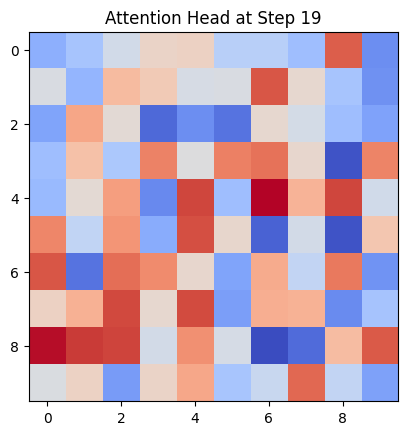

In [6]:
fig, ax = plt.subplots()

def update(frame):
    ax.clear()
    attn_weights = np.random.rand(10, 10)
    ax.imshow(attn_weights, cmap='coolwarm', interpolation='nearest')
    ax.set_title(f"Attention Head at Step {frame}")

ani = animation.FuncAnimation(fig, update, frames=20, repeat=True)
ani.save("transformer-model.gif", writer = "pillow", fps = 5)
plt.show()

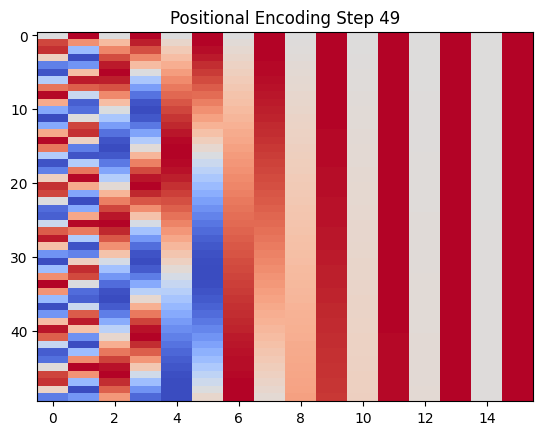

In [8]:

# Positional Encoding Function
def positional_encoding(max_len, d_model):
    pe = np.zeros((max_len, d_model))
    position = np.arange(0, max_len).reshape(-1, 1)
    div_term = np.exp(np.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
    pe[:, 0::2] = np.sin(position * div_term)
    pe[:, 1::2] = np.cos(position * div_term)
    return pe

# Generate Encoding
max_len = 50
d_model = 16
pe = positional_encoding(max_len, d_model)

# Animation Setup
fig, ax = plt.subplots()
im = ax.imshow(pe, cmap='coolwarm', aspect='auto')

def update(frame):
    im.set_data(pe[:frame, :])  # Update visualization over time
    ax.set_title(f"Positional Encoding Step {frame}")

ani = animation.FuncAnimation(fig, update, frames=max_len, interval=100, repeat=True)
ani.save("postitional-encoding.gif", writer = "pillow", fps = 5)
plt.show()

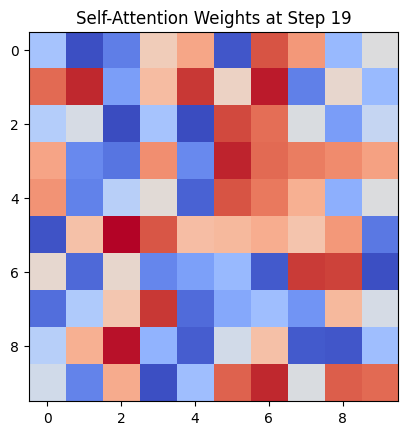

In [9]:

# Simulate random self-attention weights for animation
seq_length = 10
frames = 20

fig, ax = plt.subplots()
im = ax.imshow(torch.rand(seq_length, seq_length).numpy(), cmap='coolwarm', interpolation='nearest')

def update(frame):
    ax.clear()
    attn_weights = torch.rand(seq_length, seq_length).numpy()
    im = ax.imshow(attn_weights, cmap='coolwarm', interpolation='nearest')
    ax.set_title(f"Self-Attention Weights at Step {frame}")
    return im,

ani = animation.FuncAnimation(fig, update, frames=frames, interval=200, repeat=True)
ani.save("self-attention.gif", writer = "pillow", fps = 5)
plt.show()


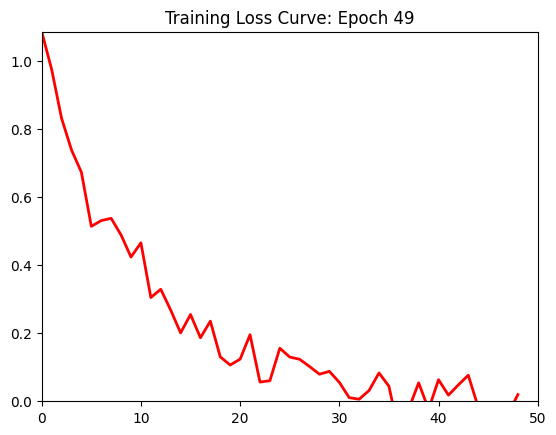

In [10]:

# Simulated training loss values
epochs = 50
train_loss = np.exp(-0.1 * np.arange(epochs)) + 0.05 * np.random.randn(epochs)

fig, ax = plt.subplots()
ax.set_xlim(0, epochs)
ax.set_ylim(0, max(train_loss))
line, = ax.plot([], [], 'r-', linewidth=2)

def update(frame):
    line.set_data(np.arange(frame), train_loss[:frame])
    ax.set_title(f"Training Loss Curve: Epoch {frame}")
    return line,

ani = animation.FuncAnimation(fig, update, frames=epochs, interval=100, repeat=False)
ani.save("training-loss-transformer.gif", writer = "pillow", fps = 5)
plt.show()


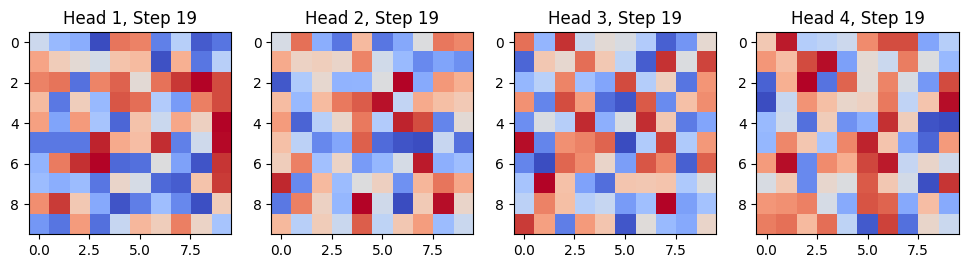

In [11]:
fig, axes = plt.subplots(1, 4, figsize=(12, 4))  # 4 attention heads

def update(frame):
    for i in range(4):
        axes[i].clear()
        attn_weights = torch.rand(seq_length, seq_length).numpy()
        axes[i].imshow(attn_weights, cmap='coolwarm', interpolation='nearest')
        axes[i].set_title(f"Head {i+1}, Step {frame}")

ani = animation.FuncAnimation(fig, update, frames=frames, interval=200, repeat=True)
ani.save("multi-head-attention.gif", writer = "pillow", fps = 5)
plt.show()
